In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import random
import math

from torch import nn

from prnn.utils.data import generate_trajectories, create_dataloader
from prnn.utils.env import make_env
from prnn.utils.agent import RandomActionAgent, RandomHDAgent, RatInABoxAgent
from prnn.utils.predictiveNet import PredictiveNet

In [3]:
import matplotlib.pyplot as plt

In [4]:
# env_key is the one you put in RatEnvironment.py
# package is the one you put in env.py

env = make_env(env_key='cheeseboard2', package='ratinabox_colors_Reward', act_enc='ContSpeedOnehotHD', FoV_params={"spatial_resolution": 0.05,
                           "angle_range": [0, 30],
                           "distance_range": [0.0, 1.2],
                           "beta": 10,
                           "walls_occlude": False
                           }) #add FoV here
agent = RatInABoxAgent('_')

/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/.venv/lib/python3.9/site-packages/ratinabox/utils.py:909: UserWarning: Found 1 unexpected params key(s) while initializing FieldOfViewBVCs object: 'walls_occlude'.
If you intended to set this parameter, ignore this message. To see all default parameters for this class call FieldOfViewBVCs.get_all_default_params().
  warnings.warn(


In [5]:
# to test if you collect observations correctly
# obs should be a tuple of two tensors
# act should be a tensor

obs, act, state, render = env.collectObservationSequence(agent, 50000)

In [6]:
total_steps = len(env.ag.history["t"])  
print("Total steps: ", total_steps)
#look at the history of the reward cell

Total steps:  50001


    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


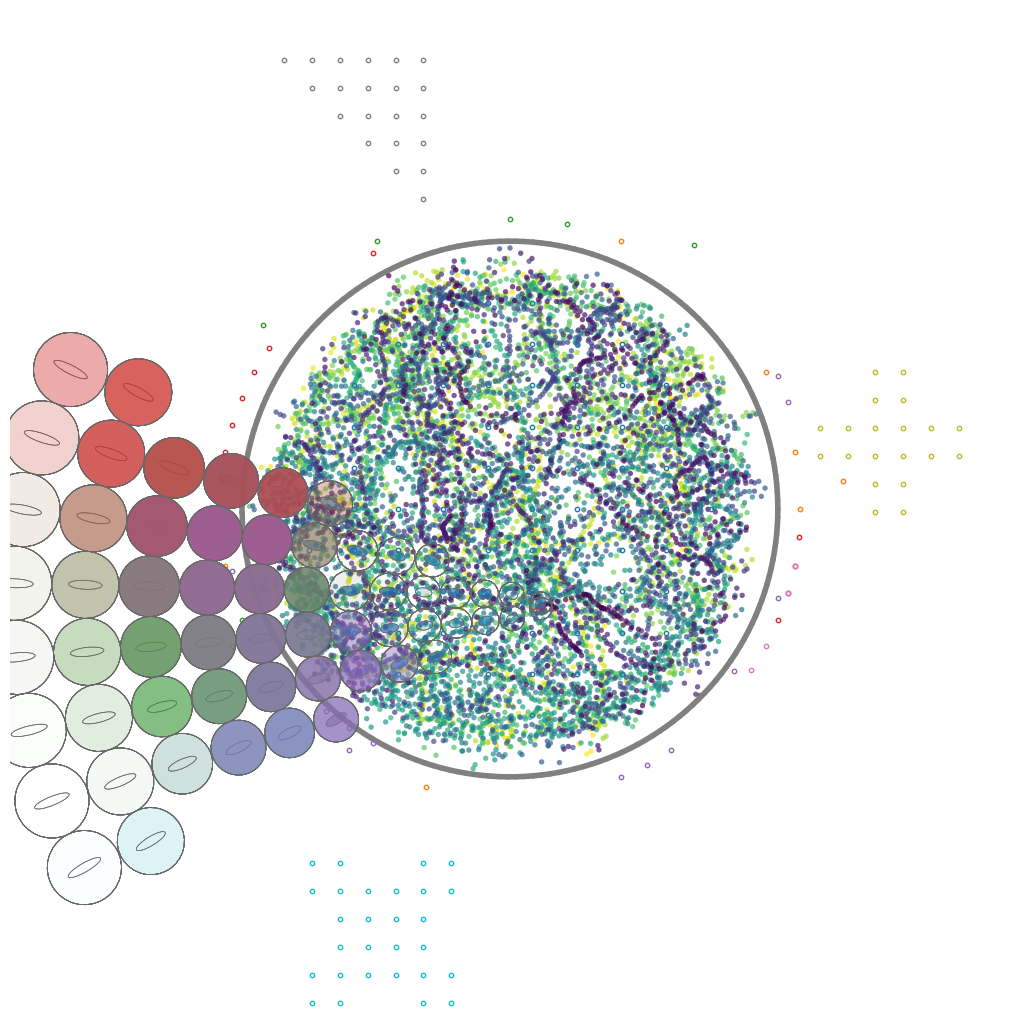

In [7]:
 
# fig = plt.figure(figsize=(10, 10))
# ax = plt.subplot(1,1,1)
fig, ax = plt.subplots(figsize=(10,10))
env.show_state_traj(40000, 50000, fig, ax) 

In [8]:
import matplotlib.pyplot as plt

#env.ValNeur.history
import numpy as np
vals = np.array(env.ValNeur.history["firingrate"])[:,2]   # third neuron
vals.max()    # ➜ ~0.060

AttributeError: 'RiaBColorsRewardShell' object has no attribute 'ValNeur'

In [ ]:
env.active_reward_idx

0

In [ ]:


prednet = PredictiveNet(env, pRNNtype='multRNN_5win_i01_o01')

In [ ]:
# to test if pRNN works correctly with these observations

obs_pred, _, _ = prednet.predict(obs, act)

In [ ]:

env.vision[1].sigma_distances

print(env.vision[1].sigma_distances.shape)
test_distances = np.full((60,), 0.5)
env.vision[1].sigma_distances
test_distances


(60,)


array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [ ]:
env.vision[1].sigma_angles
test_angles = np.full((60,), 5.)

obs shape:  torch.Size([1, 100001, 180])
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)


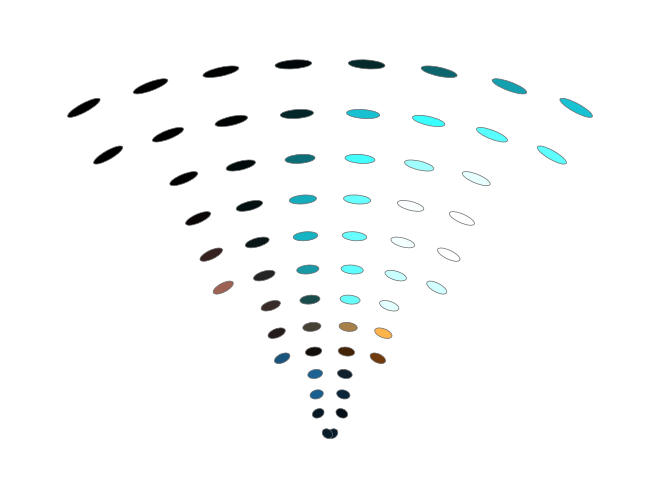

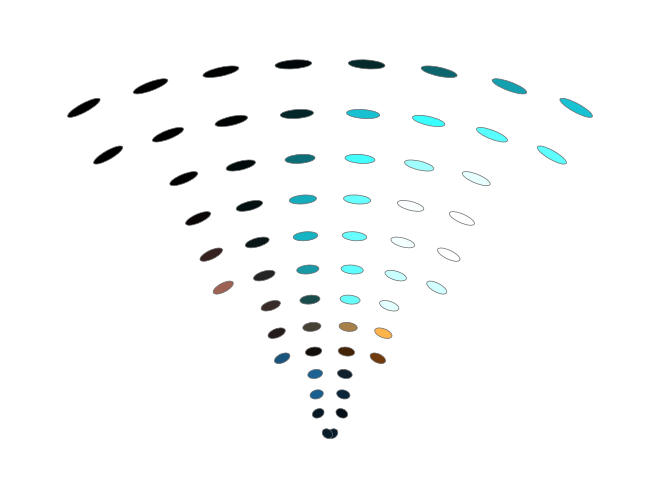

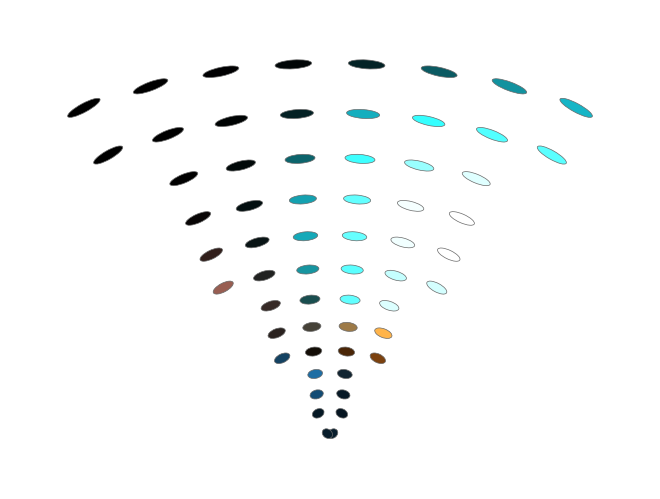

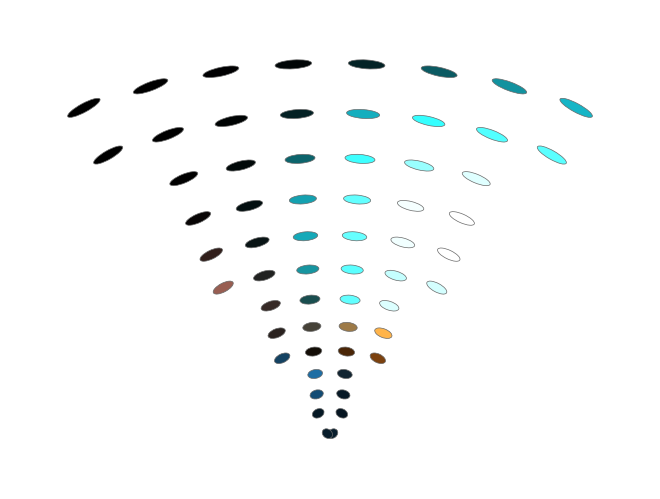

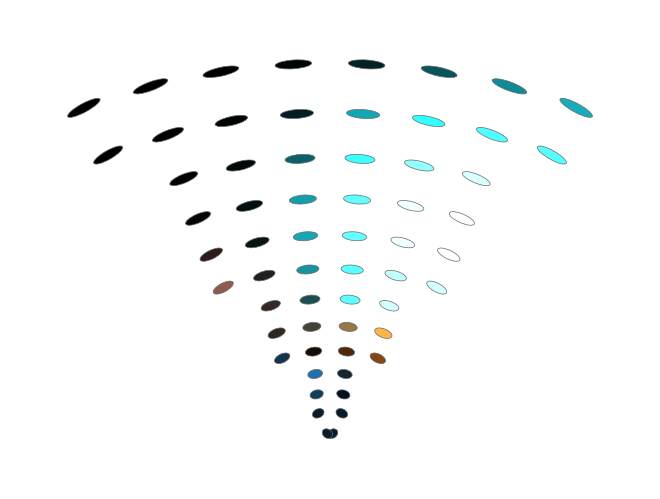

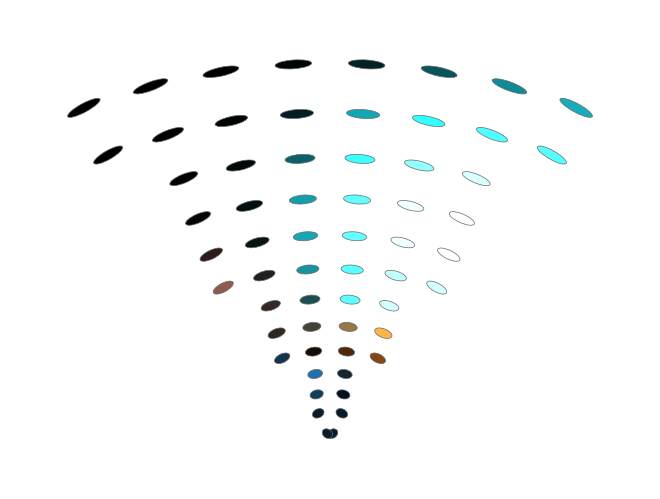

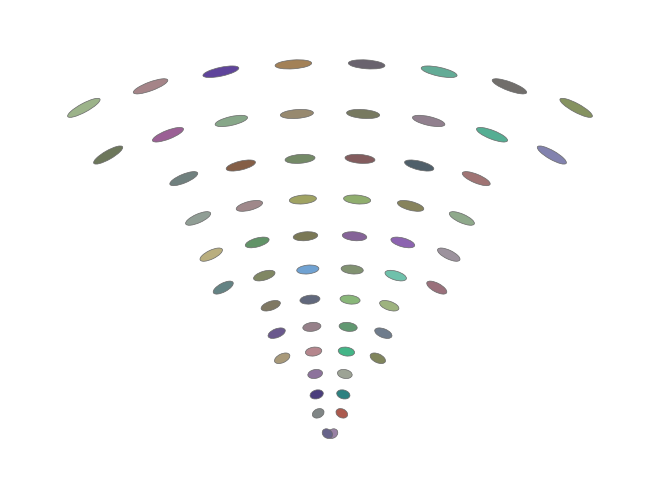

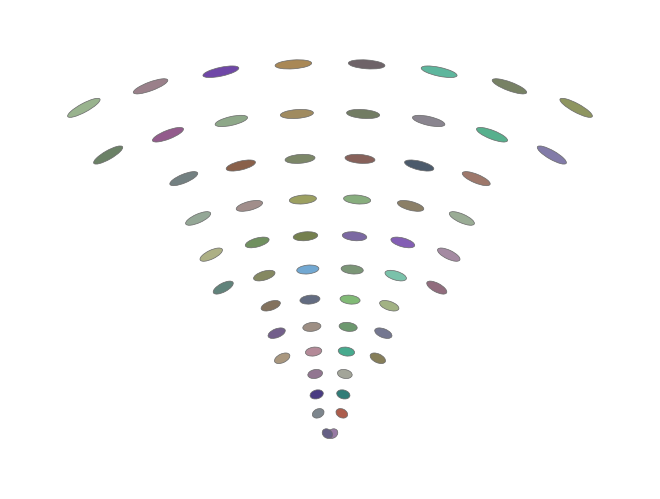

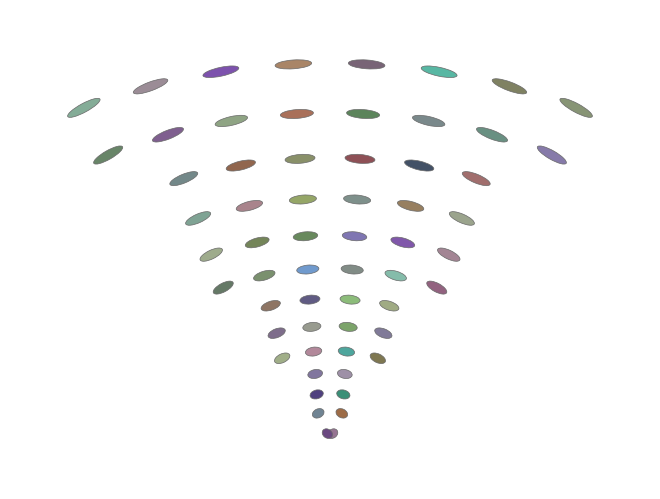

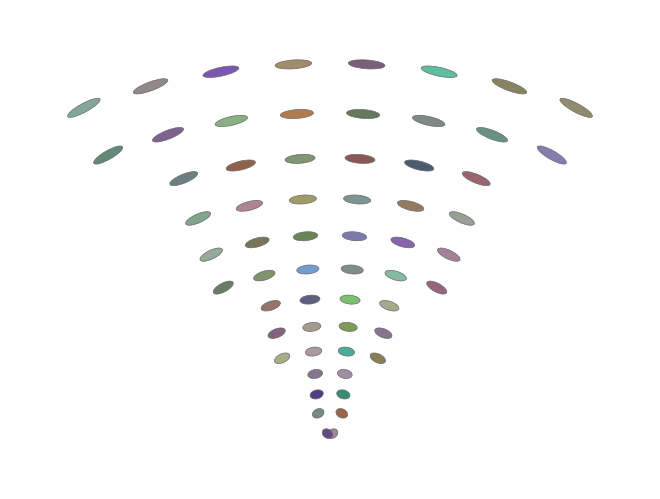

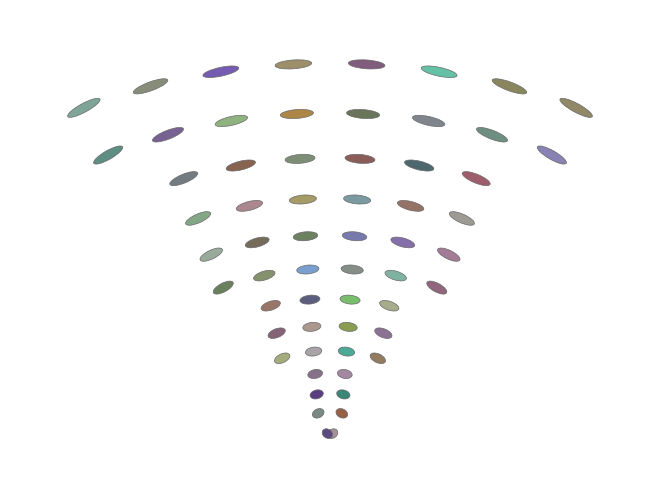

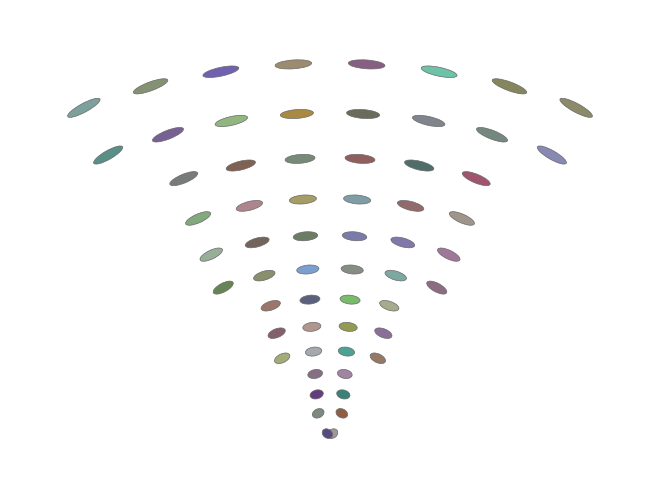

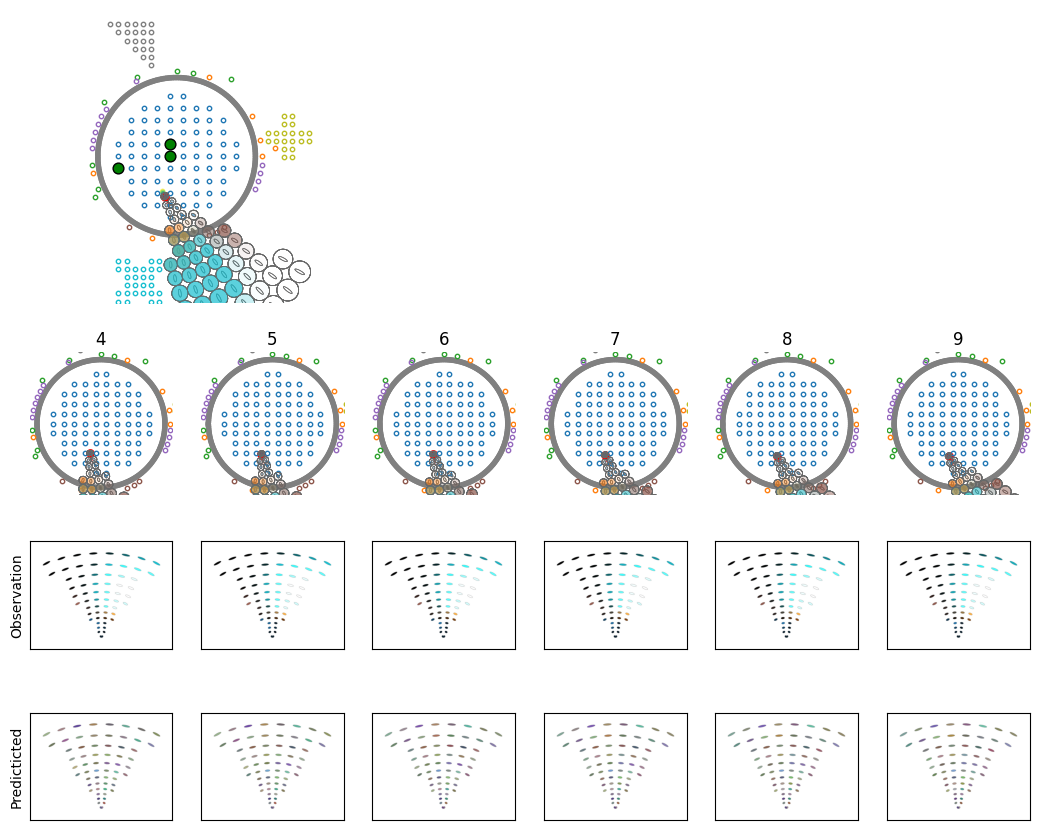

In [ ]:
print("obs shape: ", obs[0].shape)
prednet.plotObservationSequence(obs, render, obs_pred, state, timesteps=range(4,10))

In [ ]:
# when you're sure that everything's set, you may want to generate some data with this
# it will save a bunch of trajectories in the folder you specify, and then you can train pRNNs faster
# withput having to collect data every time

#generate_trajectories(env, agent, n_trajs=10240, seq_length=1000, folder='Data')
generate_trajectories(env, agent, n_trajs=100, seq_length=1000, folder='Data')

Found existing data, will generate more data if needed


In [ ]:
create_dataloader(env, agent, 100, 1000,
                          'Data', batch_size=4, num_workers=1)

Found existing data, will generate more data if needed


In [ ]:
# when you have data generated, you can test if everything goes smoothly with this

prednet.useDataLoader = True
prednet.trainingEpoch(env, agent,
                            sequence_duration=500,
                            num_trials=10,
                            batch_size=2)

Training pRNN on cpu...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x160 and 196x500)

In [ ]:
# when you will have nets already trained, this function is what you need to load them
# by default your path should be what comes after "nets/" and before ".pkl"

prednet = PredictiveNet.loadNet('PATH TO YOUR NET')

FileNotFoundError: [Errno 2] No such file or directory: 'nets/PATH TO YOUR NET.pkl'

In [ ]:
# At some point this may be helpful to debug the whole pipeline, you'll just need to change some parameters below


%run trainNet_prnn.py --savefolder='test/' --pRNNtype='multRNN_5win_i01_o01' \
        --sparsity=0.1 --mean_std_ratio=1 --eg_weight_decay=1e-8 --eg_lr=2e-3 \
        --env='cheeseboard' --env_package='ratinabox_colors_Reward' --agent='RatInABoxAgent' \
        --seqdur=1000 --lr=2e-3 --numepochs=6 --numtrials=1024 --hiddensize=500 --noisestd=0.05 \
        --bias_lr=0.2 --trainBias --ntimescale=2 --actenc='ContSpeedOnehotHD' --batch_size=8 --datasetSize=10240 \
        --datasetfolder='/Data' --namext='ContSpeedOnehotHD' -s=8 --saveTrainData #TODO: update data